## **Correlation between news and stock movement**

----
----

### **Setup & Load the Data**
---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import pytz
from IPython.display import display
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

In [2]:
# Load a CSV file from local file system
df_news = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/raw_analyst_ratings_cleaned.csv')

df_historical = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/historical_data_of_all_tickers_cleaned.csv')

df_news.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A


### **Data preparation**

In [3]:
def preprocess_headline(text):
    # Remove punctuation and non-alphabetic characters, lowercase, and strip whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

df_news['clean_headline'] = df_news['headline'].apply(preprocess_headline)
df_news[['headline', 'clean_headline']].head()

,headline,clean_headline
0,Stocks That Hit 52-Week Highs On Friday,stocks that hit week highs on friday
1,Stocks That Hit 52-Week Highs On Wednesday,stocks that hit week highs on wednesday
2,71 Biggest Movers From Friday,biggest movers from friday
3,46 Stocks Moving In Friday's Mid-Day Session,stocks moving in fridays midday session
4,B of A Securities Maintains Neutral on Agilent...,b of a securities maintains neutral on agilent...


---

### **Sentiment Analysis on Headlines**

### **Sentiment Analysis Explanation**

Sentiment analysis is a natural language processing (NLP) technique used to determine the emotional tone or subjective information within text data. In the context of financial news, sentiment analysis helps quantify the positivity, negativity, or neutrality of news headlines related to specific stocks.

**Workflow in This Notebook:**
- **Text Preprocessing:** News headlines are cleaned by removing punctuation, converting to lowercase, and stripping whitespace.
- **Sentiment Scoring:** Each cleaned headline is analyzed using the TextBlob library, which assigns a sentiment polarity score ranging from -1 (very negative) to +1 (very positive).
- **Tone Categorization:** Based on the sentiment score, headlines are classified into three tones:
    - **Positive:** Score > 0.05
    - **Negative:** Score < -0.05
    - **Neutral:** Otherwise

By aggregating these sentiment scores daily for each stock, we can explore how news sentiment correlates with stock price movements and returns. This analysis provides insights into the potential impact of market sentiment on financial performance.

In [4]:
from textblob import TextBlob

# Filter the DataFrame for specific stocks
selected_stocks = ['AAPL', 'AMZN', 'GOOG', 'FB', 'MSFT', 'NVDA', 'TSLA']
filtered_sentiment = df_news[df_news['stock'].isin(selected_stocks)].copy()

# Reset the index of the DataFrame
filtered_sentiment.reset_index(drop=True, inplace=True)

# Assign sentiment polarity scores to each clean_headline
filtered_sentiment['sentiment_score'] = filtered_sentiment['clean_headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Define a function to categorize sentiment scores into tones
def tone_from_score(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

filtered_sentiment['tone'] = filtered_sentiment['sentiment_score'].apply(tone_from_score)
filtered_sentiment[['stock','clean_headline', 'sentiment_score', 'tone']].head()

,stock,clean_headline,sentiment_score,tone
0,AAPL,tech stocks and faangs strong again to start d...,0.433333,positive
1,AAPL,biggest price target changes for wednesday,0.000000,neutral
2,AAPL,benzinga pros top stocks to watch for wed jun...,0.500000,positive
3,AAPL,deutsche bank maintains buy on apple raises pr...,0.000000,neutral
4,AAPL,apple to let users trade in their mac computer...,0.000000,neutral


In [5]:
# Convert 'date' column to datetime and extract just the date part
filtered_sentiment['date_only'] = pd.to_datetime(filtered_sentiment['date']).dt.date

# Aggregate sentiment scores by date and stock, taking the average
daily_sentiment = filtered_sentiment.groupby(['stock', 'date_only'])['sentiment_score'].mean().reset_index()

# Define a function to categorize sentiment scores into tones
def tone_from_score(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

daily_sentiment['tone'] = daily_sentiment['sentiment_score'].apply(tone_from_score)
daily_sentiment.head()

daily_sentiment.head()


,stock,date_only,sentiment_score,tone
0,AAPL,2020-06-09,0.088333,positive
1,AAPL,2020-06-10,0.166919,positive
2,AMZN,2020-06-09,-0.020833,neutral
3,AMZN,2020-06-10,0.204798,positive
4,FB,2020-06-08,0.000000,neutral


### **Daily Stock Returns**

In this section, we analyze the daily returns of selected stocks and align them with the sentiment scores derived from news headlines. By merging historical price data with daily sentiment, we can observe how market sentiment may relate to actual stock performance.

- **Daily Returns Calculation:**  
    For each stock, the daily return is computed as the percentage change in closing price from the previous trading day. This metric helps quantify the day-to-day movement of stock prices.

- **Data Alignment:**  
    The daily returns are merged with the corresponding sentiment scores for each stock and date. This alignment ensures that we only consider dates where both sentiment and price data are available.

- **Tone Categorization:**  
    Sentiment scores are further categorized into tones (positive, neutral, negative) to facilitate analysis of how different sentiment types may influence or correlate with stock returns.

This combined dataset (`aligned_returns`) enables us to explore the relationship between news sentiment and stock price movements, providing insights into the potential impact of market sentiment on financial performance.

In [6]:
# Convert 'Date' column to datetime and extract just the date part for alignment
df_historical['date_only'] = pd.to_datetime(df_historical['Date']).dt.date

# Filter for selected stocks
filtered_prices = df_historical[df_historical['Ticker'].isin(selected_stocks)].copy()

# Sort for correct pct_change calculation
filtered_prices.sort_values(['Ticker', 'date_only'], inplace=True)

# Calculate daily returns for each stock
filtered_prices['daily_return'] = filtered_prices.groupby('Ticker')['Close'].pct_change()

# Align with sentiment data: keep only dates present in daily_sentiment
aligned_returns = filtered_prices.merge(
    daily_sentiment,
    left_on=['Ticker', 'date_only'],
    right_on=['stock', 'date_only'],
    how='inner'
)[['Ticker', 'date_only', 'Close', 'daily_return', 'sentiment_score']]

# Define a function to categorize sentiment scores into tones
def tone_from_score(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

aligned_returns['tone'] = aligned_returns['sentiment_score'].apply(tone_from_score)
aligned_returns.head()

aligned_returns.head()

,Ticker,date_only,Close,daily_return,sentiment_score,tone
0,AAPL,2020-06-09,85.997498,0.031578,0.088333,positive
1,AAPL,2020-06-10,88.209999,0.025728,0.166919,positive
2,AMZN,2020-06-09,130.042999,0.030427,-0.020833,neutral
3,AMZN,2020-06-10,132.372498,0.017913,0.204798,positive
4,FB,2020-06-08,231.399994,0.002730,0.000000,neutral


----

### **Correlation Analysis**

#### **Sentiment vs. Stock Returns**

To quantitatively assess the relationship between daily news sentiment and stock performance, we compute the correlation between `sentiment_score` and `daily_return` for each stock in the `aligned_returns` DataFrame.

- **Pearson Correlation Coefficient:**  
    This metric measures the linear relationship between sentiment scores and daily returns. A positive value indicates that higher sentiment scores are associated with higher returns, while a negative value suggests the opposite.

- **Analysis Steps:**  
    1. Group the data by stock ticker.
    2. Calculate the Pearson correlation between `sentiment_score` and `daily_return` for each stock.
    3. Interpret the results to understand the strength and direction of the relationship.

This analysis helps determine whether news sentiment can serve as a useful indicator for short-term stock price movements.

c:\Users\Admin\OneDrive\10 Academy\Week 1\GitHub Rrepository\News_Sentiment_Driven_Price_Prediction\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Admin\OneDrive\10 Academy\Week 1\GitHub Rrepository\News_Sentiment_Driven_Price_Prediction\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Admin\OneDrive\10 Academy\Week 1\GitHub Rrepository\News_Sentiment_Driven_Price_Prediction\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5324\497034615.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

,Ticker,pearson_corr
0,AAPL,-1.000000
1,AMZN,-1.000000
2,FB,-0.828116
3,GOOG,-0.089449
4,NVDA,0.175714
5,TSLA,NaN


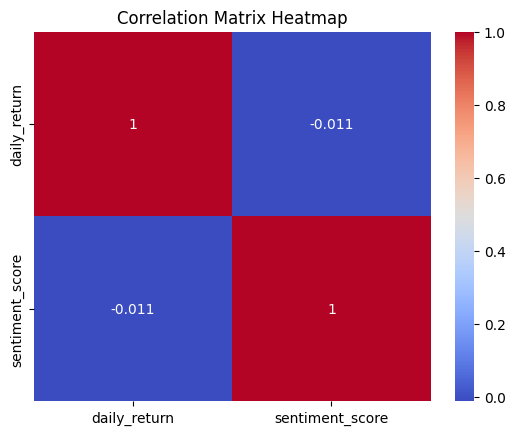

In [10]:
# Calculate Pearson correlation between sentiment_score and daily_return for each stock
correlation_results = aligned_returns.groupby('Ticker').apply(
    lambda x: x['sentiment_score'].corr(x['daily_return'])
).reset_index()
correlation_results.columns = ['Ticker', 'pearson_corr']

display(correlation_results)

corr_matrix = aligned_returns[['daily_return', 'sentiment_score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()